# MNIST Partial Questing - with Curves! For longer!

Increasing training time for this model.

## Imports

In [1]:
import random

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels, horizontal_kernel, vertical_kernel, \
    load_intermediate_labels, generate_intermediate_curve_labels, save_intermediate_labels

## Globals

In [2]:
MODEL_NAME = "./curve_partial_long.pth"

## Set Device to GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [4]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [5]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an Image

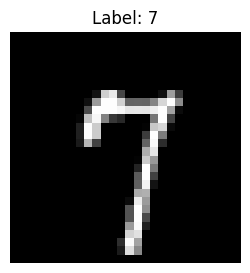

In [6]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Convolutions to get Horizontal Edges

### Example Image

In [7]:
horizontal_edges = get_edges(horizontal_kernel, sample_image)

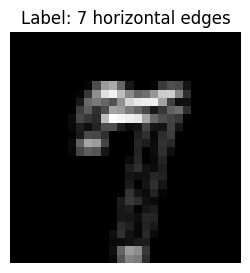

In [8]:
visualize_image(horizontal_edges, f"{sample_label} horizontal edges")

### Extending the Dataset

In [9]:
train_horizontal_image_labels = load_intermediate_labels("train_horizontal_image_labels.pkl")

In [10]:
val_horizontal_image_labels = load_intermediate_labels("val_horizontal_image_labels.pkl")

In [11]:
test_horizontal_image_labels = load_intermediate_labels("test_horizontal_image_labels.pkl")

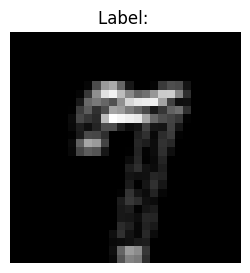

In [12]:
visualize_image(train_horizontal_image_labels[0].reshape(28, 28), "")

## Convolutions to get Vertical Edges

### Example Image

In [13]:
vertical_edges = get_edges(vertical_kernel, sample_image)

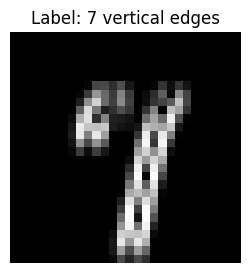

In [14]:
visualize_image(vertical_edges, f"{sample_label} vertical edges")

### Extending the Dataset

In [15]:
train_vertical_image_labels = load_intermediate_labels("train_vertical_image_labels.pkl")

In [16]:
val_vertical_image_labels = load_intermediate_labels("val_vertical_image_labels.pkl")

In [17]:
test_vertical_image_labels = load_intermediate_labels("test_vertical_image_labels.pkl")

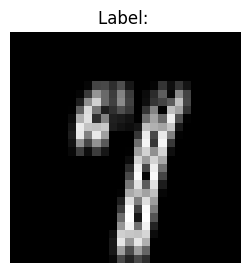

In [18]:
visualize_image(train_vertical_image_labels[0].reshape(28, 28), "")

## Convolutions to get Curves

Some extra steps here to generate better curves... this might be a point to re-visit in testing, but it largely comes from needing to rotate our curve kernel to capture curves.

The point to revisit is perhaps we want each unique rotation to be represented by an intermediate layer. Similar to how edges have been split into vertical and horizontal layers, perhaps we want layers to be dedicated to only one curve, instead of the culmination of curves.

### Example Image

In [19]:
curves = generate_intermediate_curve_labels([sample_image])

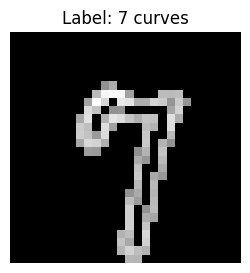

In [20]:
visualize_image(curves[0].reshape(28, 28), f"{sample_label} curves")

### Extending the dataset

In [21]:
train_curve_labels = load_intermediate_labels("train_curve_labels.pkl")

In [22]:
val_curve_labels = load_intermediate_labels("val_curve_labels.pkl")

In [23]:
test_curve_labels = load_intermediate_labels("test_curve_labels.pkl")

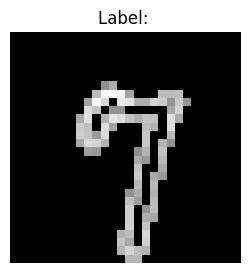

In [24]:
visualize_image(train_curve_labels[0].reshape(28, 28), "")

# Base Test

## Architecture

Updating the architecture to take into account our new curve layer.

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.curve_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal processing
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical processing
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # curve processing
        curve_out = self.curve_layer(vertical_act)
        curve_act = self.activation_function(curve_out)

        # classification
        classification_out = self.classification_layer(curve_act)
        
        return classification_out, curve_act, vertical_act, horizontal_act

In [26]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [27]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()
horizontal_loss_fn = nn.MSELoss()
vertical_loss_fn = nn.MSELoss()
curve_loss_fn = nn.MSELoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [28]:
print(f"Model weights (to compare below): {model.horizontal_layer.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### Verify Reproducibility

In [29]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [30]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges, curves):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges
        self.curves = curves

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx]).float(),
            torch.tensor(self.labels[idx], dtype=torch.long),
            torch.from_numpy(self.horizontal_edges[idx]).float(),
            torch.from_numpy(self.vertical_edges[idx]).float(),
            torch.from_numpy(self.curves[idx]).float(),
        )

In [31]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [32]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels, train_curve_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels, val_curve_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels, test_curve_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

In [33]:
num_epochs = 150
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, horizontal_labels, vertical_labels, curve_labels = batch
        images, labels, horizontal_labels, vertical_labels, curve_labels = images.to(device), \
            labels.to(device), \
            horizontal_labels.to(device), \
            vertical_labels.to(device), \
            curve_labels.to(device)
        
        # forward pass
        classification_out, curve_act, vertical_act, horizontal_act = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()

        # curve_loss 
        curve_loss = curve_loss_fn(curve_act, curve_labels)
        
        # vertical loss
        vertical_loss = vertical_loss_fn(vertical_act, vertical_labels)

        # horizontal loss
        horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels)

        # classification loss
        classification_loss = classification_loss_fn(classification_out, labels)

        # total loss
        total_loss = curve_loss + vertical_loss + horizontal_loss + classification_loss
        total_loss.backward()
        
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=classification_loss.item())

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_NAME)

Epoch 1/150
  Train Loss: 3580.4712
  Val Loss: 1.1020 | Val Acc: 85.12%


Epoch 2/150
  Train Loss: 2754.4204
  Val Loss: 1.6358 | Val Acc: 83.15%


Epoch 3/150
  Train Loss: 2531.2976
  Val Loss: 1.3231 | Val Acc: 87.41%


Epoch 4/150
  Train Loss: 2413.7090
  Val Loss: 1.2175 | Val Acc: 88.36%


Epoch 5/150
  Train Loss: 2344.2314
  Val Loss: 1.7357 | Val Acc: 84.38%


Epoch 6/150
  Train Loss: 2291.4606
  Val Loss: 1.5160 | Val Acc: 86.52%


Epoch 7/150
  Train Loss: 2254.3216
  Val Loss: 1.5053 | Val Acc: 86.97%


Epoch 8/150
  Train Loss: 2226.4778
  Val Loss: 1.5227 | Val Acc: 86.87%


Epoch 9/150
  Train Loss: 2206.2911
  Val Loss: 1.4808 | Val Acc: 87.91%


Epoch 10/150
  Train Loss: 2187.8195
  Val Loss: 1.3387 | Val Acc: 88.97%


Epoch 11/150
  Train Loss: 2175.7087
  Val Loss: 1.3883 | Val Acc: 88.69%


Epoch 12/150
  Train Loss: 2164.5826
  Val Loss: 1.6075 | Val Acc: 86.92%


Epoch 13/150
  Train Loss: 2156.0861
  Val Loss: 1.7124 | Val Acc: 86.45%


Epoch 14/150
  Train Loss: 2146.5401
  Val Loss: 1.6818 | Val Acc: 87.29%


Epoch 15/150
  Train Loss: 2138.2241
  Val Loss: 1.6861 | Val Acc: 86.59%


Epoch 16/150
  Train Loss: 2132.8028
  Val Loss: 1.5105 | Val Acc: 88.66%


Epoch 17/150
  Train Loss: 2126.3055
  Val Loss: 1.3907 | Val Acc: 89.17%


Epoch 18/150
  Train Loss: 2121.1601
  Val Loss: 1.4746 | Val Acc: 88.33%


Epoch 19/150
  Train Loss: 2115.2517
  Val Loss: 1.8051 | Val Acc: 86.76%


Epoch 20/150
  Train Loss: 2112.4563
  Val Loss: 1.7237 | Val Acc: 86.83%


Epoch 21/150
  Train Loss: 2107.3055
  Val Loss: 1.4014 | Val Acc: 88.65%


Epoch 22/150
  Train Loss: 2100.6902
  Val Loss: 1.4324 | Val Acc: 88.80%


Epoch 23/150
  Train Loss: 2097.2439
  Val Loss: 1.7244 | Val Acc: 87.09%


Epoch 24/150
  Train Loss: 2094.8167
  Val Loss: 1.4810 | Val Acc: 88.45%


Epoch 25/150
  Train Loss: 2092.2110
  Val Loss: 1.5234 | Val Acc: 87.68%


Epoch 26/150
  Train Loss: 2087.4691
  Val Loss: 1.5570 | Val Acc: 87.43%


Epoch 27/150
  Train Loss: 2083.9350
  Val Loss: 1.7831 | Val Acc: 87.26%


Epoch 28/150
  Train Loss: 2084.2553
  Val Loss: 1.6261 | Val Acc: 87.67%


Epoch 29/150
  Train Loss: 2080.6241
  Val Loss: 1.4316 | Val Acc: 89.00%


Epoch 30/150
  Train Loss: 2081.3331
  Val Loss: 1.6460 | Val Acc: 88.08%


Epoch 31/150
  Train Loss: 2076.8561
  Val Loss: 1.5915 | Val Acc: 88.27%


Epoch 32/150
  Train Loss: 2075.3839
  Val Loss: 2.0641 | Val Acc: 85.34%


Epoch 33/150
  Train Loss: 2075.7571
  Val Loss: 1.5395 | Val Acc: 88.71%


Epoch 34/150
  Train Loss: 2070.3418
  Val Loss: 1.4888 | Val Acc: 88.59%


Epoch 35/150
  Train Loss: 2070.3894
  Val Loss: 1.7149 | Val Acc: 87.25%


Epoch 36/150
  Train Loss: 2070.5496
  Val Loss: 1.5804 | Val Acc: 87.99%


Epoch 37/150
  Train Loss: 2065.7162
  Val Loss: 1.5010 | Val Acc: 88.83%


Epoch 38/150
  Train Loss: 2065.2173
  Val Loss: 1.6261 | Val Acc: 87.77%


Epoch 39/150
  Train Loss: 2062.7526
  Val Loss: 1.8396 | Val Acc: 86.34%


Epoch 40/150
  Train Loss: 2062.4031
  Val Loss: 1.8294 | Val Acc: 86.52%


Epoch 41/150
  Train Loss: 2057.3786
  Val Loss: 1.5868 | Val Acc: 88.60%


Epoch 42/150
  Train Loss: 2061.2895
  Val Loss: 1.5504 | Val Acc: 88.22%


Epoch 43/150
  Train Loss: 2058.2225
  Val Loss: 1.8756 | Val Acc: 86.43%


Epoch 44/150
  Train Loss: 2056.1420
  Val Loss: 1.3954 | Val Acc: 89.83%


Epoch 45/150
  Train Loss: 2054.9261
  Val Loss: 2.1085 | Val Acc: 85.34%


Epoch 46/150
  Train Loss: 2055.1400
  Val Loss: 1.7016 | Val Acc: 87.06%


Epoch 47/150
  Train Loss: 2053.7540
  Val Loss: 1.8170 | Val Acc: 86.93%


Epoch 48/150
  Train Loss: 2052.5964
  Val Loss: 1.7968 | Val Acc: 87.54%


Epoch 49/150
  Train Loss: 2051.3102
  Val Loss: 1.7790 | Val Acc: 86.86%


Epoch 50/150
  Train Loss: 2051.6154
  Val Loss: 1.6367 | Val Acc: 87.74%


Epoch 51/150
  Train Loss: 2050.7441
  Val Loss: 2.0426 | Val Acc: 84.29%


Epoch 52/150
  Train Loss: 2049.0798
  Val Loss: 1.9356 | Val Acc: 86.28%


Epoch 53/150
  Train Loss: 2048.0799
  Val Loss: 2.7396 | Val Acc: 81.10%


Epoch 54/150
  Train Loss: 2047.9633
  Val Loss: 1.7935 | Val Acc: 87.88%


Epoch 55/150
  Train Loss: 2048.2783
  Val Loss: 1.6501 | Val Acc: 87.53%


Epoch 56/150
  Train Loss: 2045.0365
  Val Loss: 1.7359 | Val Acc: 87.77%


Epoch 57/150
  Train Loss: 2045.2326
  Val Loss: 1.5183 | Val Acc: 88.65%


Epoch 58/150
  Train Loss: 2046.6162
  Val Loss: 2.0195 | Val Acc: 85.60%


Epoch 59/150
  Train Loss: 2037.8227
  Val Loss: 1.5457 | Val Acc: 89.07%


Epoch 60/150
  Train Loss: 2040.0885
  Val Loss: 1.6317 | Val Acc: 87.93%


Epoch 61/150
  Train Loss: 2039.0795
  Val Loss: 1.4985 | Val Acc: 88.54%


Epoch 62/150
  Train Loss: 2037.9384
  Val Loss: 2.5337 | Val Acc: 83.30%


Epoch 63/150
  Train Loss: 2035.4721
  Val Loss: 1.5941 | Val Acc: 87.84%


Epoch 64/150
  Train Loss: 2033.2483
  Val Loss: 1.7019 | Val Acc: 87.33%


Epoch 65/150
  Train Loss: 2034.8671
  Val Loss: 2.1848 | Val Acc: 85.13%


Epoch 66/150
  Train Loss: 2033.6453
  Val Loss: 1.7221 | Val Acc: 87.57%


Epoch 67/150
  Train Loss: 2034.3393
  Val Loss: 1.6162 | Val Acc: 88.12%


Epoch 68/150
  Train Loss: 2031.7330
  Val Loss: 1.8444 | Val Acc: 86.80%


Epoch 69/150
  Train Loss: 2032.6824
  Val Loss: 1.6487 | Val Acc: 88.32%


Epoch 70/150
  Train Loss: 2033.7823
  Val Loss: 1.8357 | Val Acc: 87.28%


Epoch 71/150
  Train Loss: 2030.1076
  Val Loss: 1.7741 | Val Acc: 87.27%


Epoch 72/150
  Train Loss: 2030.8656
  Val Loss: 1.4658 | Val Acc: 89.26%


Epoch 73/150
  Train Loss: 2029.2109
  Val Loss: 1.8531 | Val Acc: 87.41%


Epoch 74/150
  Train Loss: 2029.1719
  Val Loss: 1.4668 | Val Acc: 88.74%


Epoch 75/150
  Train Loss: 2028.7911
  Val Loss: 1.6622 | Val Acc: 87.49%


Epoch 76/150
  Train Loss: 2026.6796
  Val Loss: 1.4950 | Val Acc: 89.31%


Epoch 77/150
  Train Loss: 2026.6395
  Val Loss: 1.4806 | Val Acc: 89.68%


Epoch 78/150
  Train Loss: 2026.8154
  Val Loss: 2.1916 | Val Acc: 85.23%


Epoch 79/150
  Train Loss: 2024.8448
  Val Loss: 1.6186 | Val Acc: 87.46%


Epoch 80/150
  Train Loss: 2026.0472
  Val Loss: 1.7581 | Val Acc: 87.87%


Epoch 81/150
  Train Loss: 2023.1907
  Val Loss: 1.4701 | Val Acc: 89.05%


Epoch 82/150
  Train Loss: 2024.6905
  Val Loss: 1.7448 | Val Acc: 86.80%


Epoch 83/150
  Train Loss: 2023.0764
  Val Loss: 1.4861 | Val Acc: 88.72%


Epoch 84/150
  Train Loss: 2022.7579
  Val Loss: 1.8882 | Val Acc: 86.00%


Epoch 85/150
  Train Loss: 2022.1891
  Val Loss: 1.7132 | Val Acc: 87.96%


Epoch 86/150
  Train Loss: 2021.8118
  Val Loss: 1.6586 | Val Acc: 88.10%


Epoch 87/150
  Train Loss: 2019.8411
  Val Loss: 1.6751 | Val Acc: 88.21%


Epoch 88/150
  Train Loss: 2020.0602
  Val Loss: 1.7688 | Val Acc: 87.89%


Epoch 89/150
  Train Loss: 2020.4816
  Val Loss: 1.5501 | Val Acc: 88.88%


Epoch 90/150
  Train Loss: 2020.2687
  Val Loss: 1.6383 | Val Acc: 88.63%


Epoch 91/150
  Train Loss: 2019.7682
  Val Loss: 2.0559 | Val Acc: 85.34%


Epoch 92/150
  Train Loss: 2017.9430
  Val Loss: 1.8631 | Val Acc: 86.64%


Epoch 93/150
  Train Loss: 2020.0603
  Val Loss: 1.9169 | Val Acc: 85.99%


Epoch 94/150
  Train Loss: 2017.8594
  Val Loss: 1.5204 | Val Acc: 89.17%


Epoch 95/150
  Train Loss: 2014.8393
  Val Loss: 1.9472 | Val Acc: 86.72%


Epoch 96/150
  Train Loss: 2018.0358
  Val Loss: 2.2671 | Val Acc: 84.66%


Epoch 97/150
  Train Loss: 2018.3416
  Val Loss: 1.5661 | Val Acc: 88.34%


Epoch 98/150
  Train Loss: 2017.5319
  Val Loss: 1.7201 | Val Acc: 86.59%


Epoch 99/150
  Train Loss: 2018.7331
  Val Loss: 1.6677 | Val Acc: 88.32%


Epoch 100/150
  Train Loss: 2016.3145
  Val Loss: 1.7437 | Val Acc: 88.44%


Epoch 101/150
  Train Loss: 2017.0838
  Val Loss: 1.8618 | Val Acc: 86.99%


Epoch 102/150
  Train Loss: 2015.7409
  Val Loss: 1.8852 | Val Acc: 87.12%


Epoch 103/150
  Train Loss: 2014.9807
  Val Loss: 1.9762 | Val Acc: 86.71%


Epoch 104/150
  Train Loss: 2012.8237
  Val Loss: 1.6367 | Val Acc: 88.03%


Epoch 105/150
  Train Loss: 2015.9502
  Val Loss: 2.0644 | Val Acc: 86.44%


Epoch 106/150
  Train Loss: 2014.2316
  Val Loss: 1.8503 | Val Acc: 86.97%


Epoch 107/150
  Train Loss: 2014.4970
  Val Loss: 1.6920 | Val Acc: 87.19%


Epoch 108/150
  Train Loss: 2015.7480
  Val Loss: 1.5881 | Val Acc: 88.53%


Epoch 109/150
  Train Loss: 2014.0419
  Val Loss: 1.7609 | Val Acc: 87.07%


Epoch 110/150
  Train Loss: 2012.9719
  Val Loss: 1.4686 | Val Acc: 89.11%


Epoch 111/150
  Train Loss: 2013.5323
  Val Loss: 1.7455 | Val Acc: 88.01%


Epoch 112/150
  Train Loss: 2013.6293
  Val Loss: 1.9816 | Val Acc: 86.49%


Epoch 113/150
  Train Loss: 2013.6193
  Val Loss: 1.7329 | Val Acc: 87.83%


Epoch 114/150
  Train Loss: 2011.7767
  Val Loss: 1.6219 | Val Acc: 88.41%


Epoch 115/150
  Train Loss: 2013.0536
  Val Loss: 1.8217 | Val Acc: 87.25%


Epoch 116/150
  Train Loss: 2011.7488
  Val Loss: 1.7206 | Val Acc: 87.98%


Epoch 117/150
  Train Loss: 2012.4663
  Val Loss: 1.7733 | Val Acc: 87.21%


Epoch 118/150
  Train Loss: 2013.0160
  Val Loss: 2.0535 | Val Acc: 86.56%


Epoch 119/150
  Train Loss: 2011.3896
  Val Loss: 1.7145 | Val Acc: 87.30%


Epoch 120/150
  Train Loss: 2009.9561
  Val Loss: 2.0533 | Val Acc: 86.04%


Epoch 121/150
  Train Loss: 2010.8394
  Val Loss: 2.0127 | Val Acc: 85.39%


Epoch 122/150
  Train Loss: 2012.0312
  Val Loss: 1.7229 | Val Acc: 88.45%


Epoch 123/150
  Train Loss: 2010.6942
  Val Loss: 1.9950 | Val Acc: 86.26%


Epoch 124/150
  Train Loss: 2011.9501
  Val Loss: 1.7645 | Val Acc: 87.51%


Epoch 125/150
  Train Loss: 2007.4586
  Val Loss: 1.8844 | Val Acc: 86.90%


Epoch 126/150
  Train Loss: 2009.9355
  Val Loss: 2.0705 | Val Acc: 85.83%


Epoch 127/150
  Train Loss: 2007.5840
  Val Loss: 1.7664 | Val Acc: 87.56%


Epoch 128/150
  Train Loss: 2007.0500
  Val Loss: 1.9927 | Val Acc: 85.31%


Epoch 129/150
  Train Loss: 2009.6057
  Val Loss: 1.8065 | Val Acc: 87.73%


Epoch 130/150
  Train Loss: 2012.3196
  Val Loss: 1.7175 | Val Acc: 87.70%


Epoch 131/150
  Train Loss: 2007.8815
  Val Loss: 1.6216 | Val Acc: 88.19%


Epoch 132/150
  Train Loss: 2008.3285
  Val Loss: 1.6843 | Val Acc: 87.97%


Epoch 133/150
  Train Loss: 2008.1155
  Val Loss: 1.6685 | Val Acc: 88.06%


Epoch 134/150
  Train Loss: 2006.8058
  Val Loss: 1.8565 | Val Acc: 87.25%


Epoch 135/150
  Train Loss: 2007.0085
  Val Loss: 1.6795 | Val Acc: 87.40%


Epoch 136/150
  Train Loss: 2009.2072
  Val Loss: 1.6005 | Val Acc: 88.70%


Epoch 137/150
  Train Loss: 2006.1717
  Val Loss: 1.8642 | Val Acc: 87.03%


Epoch 138/150
  Train Loss: 2006.3525
  Val Loss: 1.5797 | Val Acc: 89.13%


Epoch 139/150
  Train Loss: 2007.7026
  Val Loss: 1.6123 | Val Acc: 88.94%


Epoch 140/150
  Train Loss: 2006.5697
  Val Loss: 2.1877 | Val Acc: 86.20%


Epoch 141/150
  Train Loss: 2007.0817
  Val Loss: 1.7557 | Val Acc: 87.34%


Epoch 142/150
  Train Loss: 2005.2068
  Val Loss: 2.3097 | Val Acc: 83.92%


Epoch 143/150
  Train Loss: 2007.1715
  Val Loss: 1.4429 | Val Acc: 89.58%


Epoch 144/150
  Train Loss: 2004.9233
  Val Loss: 1.7238 | Val Acc: 88.34%


Epoch 145/150
  Train Loss: 2005.7514
  Val Loss: 1.6277 | Val Acc: 88.32%


Epoch 146/150
  Train Loss: 2005.2334
  Val Loss: 2.5074 | Val Acc: 82.71%


Epoch 147/150
  Train Loss: 2005.1918
  Val Loss: 2.0419 | Val Acc: 85.89%


Epoch 148/150
  Train Loss: 2004.9265
  Val Loss: 1.9748 | Val Acc: 86.27%


Epoch 149/150
  Train Loss: 2006.3591
  Val Loss: 1.8775 | Val Acc: 87.39%


Epoch 150/150
  Train Loss: 2004.9012
  Val Loss: 1.8814 | Val Acc: 86.84%


So our training doesn't seem to really matter since loss is best in the first step. This appears to by a byproduct of our loss defintion in the training loop vs. validation loop. Ideally, we'd want the classification loss to be minimized. Perhaps we should experiment to see if minimizing training loss can help? I suspect it won't, since the side quests might counter the main quests, or we might get stuck in oscillation.

## Eval

In [34]:
model.load_state_dict(torch.load(MODEL_NAME))
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(val_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|█████████████████████████████████| 79/79 [00:00<00:00, 289.81it/s]

Final Test Accuracy: 85.12%


# Exploring Model Results

## Visualizing Weights

In [35]:
horizontal_layer_weights = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

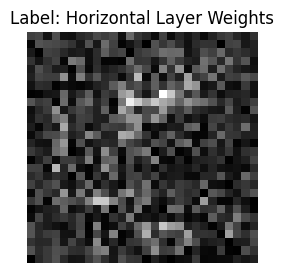

In [36]:
visualize_image(horizontal_layer_weights, "Horizontal Layer Weights")

In [37]:
vertical_layer_weights = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

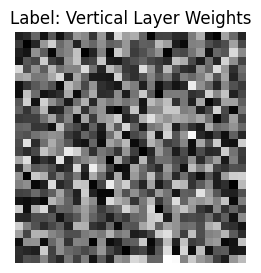

In [38]:
visualize_image(vertical_layer_weights, "Vertical Layer Weights")

In [39]:
curve_layer_weights = np.abs(model.curve_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

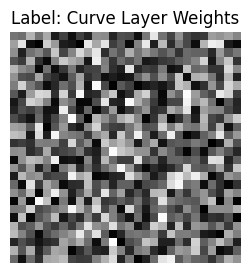

In [40]:
visualize_image(curve_layer_weights, "Curve Layer Weights")

In [41]:
classification_layer_weights = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

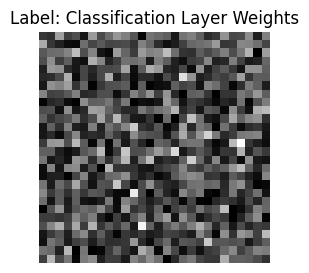

In [42]:
visualize_image(classification_layer_weights, "Classification Layer Weights")